'''
   Live Code 5

    Nama  : Kamelia Ramandha
    Batch : CODA-RMT-010

    Program ini dibuat untuk melakukan forecasting terhadap pengunjung pulau pari selama satu tahun kedepan

'''

# Importing Library

In [ ]:
# Mengimport library yang diperlukan
import pandas as pd 
import matplotlib.pyplot as plt 

# Data Loading

In [3]:
# Loading dataset dari CSV dan menetapkan header pada baris ke-1
data = pd.read_csv('multiTimeline.csv', header=1)

data.head()

,Week,Pulau Pari: (Indonesia)
0,2022-03-27,16
1,2022-04-03,13
2,2022-04-10,18
3,2022-04-17,29
4,2022-04-24,35


In [4]:
# Mengganti nama kolom agar lebih mudah dipanggil
data = data.rename(columns={'Pulau Pari: (Indonesia)':'Visitor'})

In [5]:
# Melihat informasi dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Week     126 non-null    object
 1   Visitor  126 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [6]:
# Mengubah tipe data dari kolom 'Week' menjadi datetime
data['Week'] = data['Week'].astype('datetime64[ns]')


In [7]:
# Melihat kembali informasi dataset apakah sudah terganti
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Week     126 non-null    datetime64[ns]
 1   Visitor  126 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.1 KB


In [8]:
# Melihat data duplikat
data.duplicated().sum()

np.int64(0)

In [9]:
# Melihat data kosong
data.isnull().sum()

Week       0
Visitor    0
dtype: int64

Setelah dicek, data sudah tidak ada yang duplikat dan tidak ada yang null. Maka data sampai sini sudah bersih.

# Exploratory Data Analysis (EDA)

In [10]:
# Menentukan kolom 'Week' sebagai index
data = data.set_index('Week')

<Axes: xlabel='Week'>

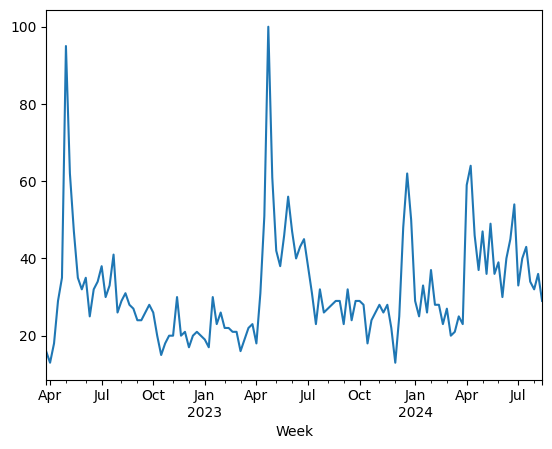

In [11]:
# Melihat plot data
data['Visitor'].plot()

Dari data di atas, dapat dilihat bahwa adanya trend naik di setiap bulan April dari tahun ke tahun. Data ini termasuk data pattern seasonal karena memiliki pola yang berulang secara teratur dalam jangka waktu tertentu.

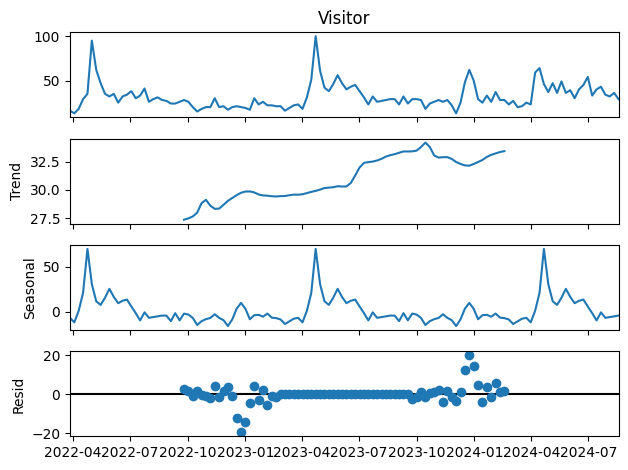

In [43]:
# Melakukan dekomposisi data. Percobaan pertama menggunakan model additive
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(data['Visitor'], model='additive')
ax=res.plot()
plt.show()

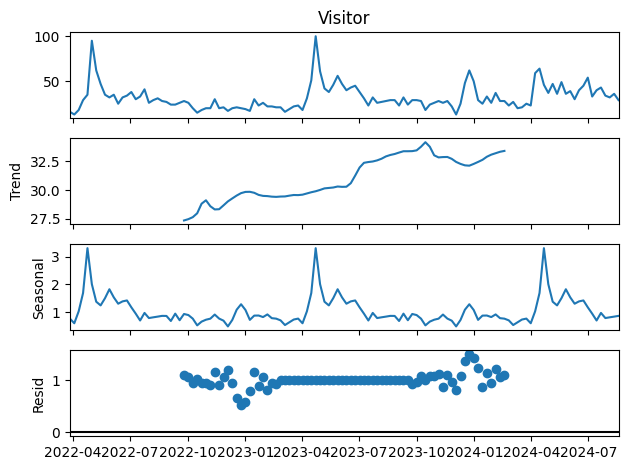

In [44]:
# Melakukan dekomposisi data. Percobaan pertama menggunakan model multiplikatif
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(data['Visitor'], model='multiplicative')
ax=res.plot()
plt.show()

Setelah melakukan dekomposisi, data lebih sesuai menggunakan metode multiplicative karena menghasilkan residual yang lebih rendah dibandingkan additive. 

Langkah selanjutnya adalah mengidentifikasi tipe musiman (seasonality) yang dimiliki data, apakah bersifat mengguan bulanan, atau tahunan, untuk memperkuat model forecasting.

In [45]:
# Melihat nilai seasonal tertinggi dan terendah
seasonal_max = res.seasonal[res.seasonal==res.seasonal.max()].reset_index()
seasonal_min = res.seasonal[res.seasonal==res.seasonal.min()].reset_index()
print(seasonal_max.head())
print(seasonal_min.head())

        Week  seasonal
0 2022-04-24  3.303952
1 2023-04-23  3.303952
2 2024-04-21  3.303952
        Week  seasonal
0 2022-12-04  0.487233
1 2023-12-03  0.487233


Dari tabel diatas, dapat disimpulkan bahwa data seasonal yang dimiliki sifatnya tahunan dengan peak di minggu terakhir April setiap tahunnya.

Sementara, low season popularitas pulau pari adalah minggu pertama bulan Desember setiap tahunnya.

Selanjutnya dilakukan pengujian apakah data sudah stationer atau belum untuk bisa melakukan prediksi.

In [15]:
# Mengimport library untuk melakukan pengujian staitionarity
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [16]:
#Melakukan pengecekan stationarity
check_stationarity(data['Visitor'])

ADF Statistic: -3.893116
p-value: 0.002086
Critical Values:
	1%: -3.485
	5%: -2.886
	10%: -2.580
Stationary


Dari hasil di atas kita bisa menyimpulkan bahwa data sudah stationer, sehingga tidak perlu dilakukan teknik differencing.

# Model Definition and Training

In [49]:
# Mengimport library dan menggunakan model ARIMA untuk menemukan AIC
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data['Visitor'].asfreq('W'), order=(1, 0, 1)) # d = 0 karena tidak dilakukan differencing
result = model.fit()
print('AIC:',result.aic)

AIC: 962.3665129581232


Namun, hasil diatas tidak bisa dijelaskan karena tidak ada nilai pembanding yang dapat digunakan.

In [19]:
# Mencari MSE dan MAE untuk evaluasi model
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('MSE:',mean_squared_error(data['Visitor'], result.predict()))
print('MAE:',mean_absolute_error(data['Visitor'], result.predict()))

MSE: 114.36129518338376
MAE: 6.880287818981712


Tingat error rata-rata model adalah sekitar 7% popularitas berdasarkan MAE, sedangkan MSE sekitar 11% popularitas, yang menunjukan ukuran eror yang sedikit lebih besar.

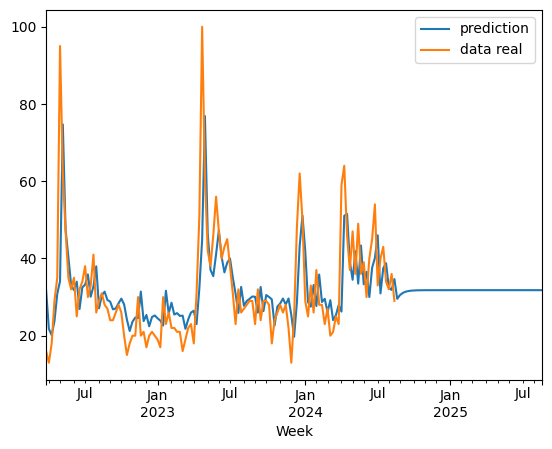

In [20]:
result.predict(0, len(data)+52).plot(label='prediction')
data['Visitor'].plot(label='data real')
plt.legend()

Setelah melihat plot dari model ARIMA di atas untuk memprediksi persentase popularitas setahun kedepan, data tidak dapat memprediksi tren di kemudian hari.

Maka, model ini belum cukup baik dan kita harus mencari kombinasi yang lebih sesuai dengan melakukan fine tuning.

# Model Improvement

In [ ]:
# Membuat fungsi untuk mencari kombinasi ARIMA terbaik
def find_best_model(data, num_p, num_d, num_q):
  df = pd.DataFrame() 
  pdq = [[],[],[]] 
  aic = [] 
  for p in range(num_p + 1): 
    for d in range(num_d + 1):
      for q in range(num_q + 1):
        
        try: 
          model = ARIMA(data, order=(p, d, q))
          result = model.fit()
          pdq[0].append(p)
          pdq[1].append(d)
          pdq[2].append(q)
          aic.append(result.aic)
        except:
          pass 

  df['p'] = pdq[0]
  df['d'] = pdq[1]
  df['q'] = pdq[2]
  df['AIC'] = aic

  df.sort_values('AIC', inplace=True)

  return df.p.iloc[0], df.d.iloc[0], df.q.iloc[0], df.AIC.iloc[0], df

In [36]:
p,d,q,AIC,df = find_best_model(data['Visitor'].asfreq('W'), 11, 0, 11)

/opt/miniconda3/envs/Hacktiv8/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/Hacktiv8/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/Hacktiv8/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/Hacktiv8/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/Hacktiv8/lib/py

In [ ]:
# Melihat kombinasi yang paling disarankan dari AIC terendah
df.head().sort_values('AIC')

,p,d,q,AIC
12,1,0,0,961.275091
2,0,0,2,961.604941
24,2,0,0,962.162996
14,1,0,2,962.336499
13,1,0,1,962.366513


Berdasarkan hasil di atas, model terbaik dengan AIC terendah adalah model yang menggunakan p=1, d=0, dan q=0

In [ ]:
# Mencari MSE dan MAE yang baru dengan model terbaik yang diberikan
model = ARIMA(data['Visitor'].asfreq('W'), order=(1, 0, 0))
result = model.fit()
print('MSE:',mean_squared_error(data['Visitor'], result.predict()))
print('MAE:',mean_absolute_error(data['Visitor'], result.predict()))

MSE: 115.17870080843304
MAE: 6.863503182081256


Nilai MSE dan MAE cenderung stabil dan tidak banyak berubah

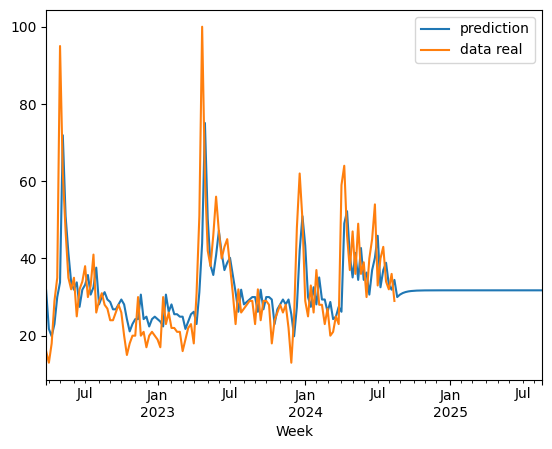

In [ ]:
# Membuat Plot
result.predict(0, len(data)+52).plot(label='prediction')
data['Visitor'].plot(label='data real')
plt.legend()

Model masih belum bisa memprediksi jumlah pengunjung dengan baik.

# Model Inference

Dari model prediksi yang sudah dibuat, model masih tergolong kurang baik dalam memprediksi popularitas kata kunci pulau pari. Prediksinya adalah per minggunya jumlah pengunjung berkisar di antara 30-32% dengan error +- 7%, sehingga rentang popularitas adalah 23-39% per minggunya.

In [ ]:
# Melihat prediksi setahun ke depan
result.predict(len(data), len(data)+365)

2024-08-25    30.002406
2024-09-01    30.638723
2024-09-08    31.042651
2024-09-15    31.299060
2024-09-22    31.461826
                ...    
2031-07-27    31.744739
2031-08-03    31.744739
2031-08-10    31.744739
2031-08-17    31.744739
2031-08-24    31.744739
Freq: W-SUN, Name: predicted_mean, Length: 366, dtype: float64